Просто ради интереса, попробуем различные методы кластеризации на тех данных, что использовали для нейронной сети, которая решает задачу классификации

In [94]:
# ну конечно подключим pandas
import pandas as pd

# куда же без нампая
import numpy as np

# display() для удобства
from IPython.display import display

# есть категориальные данные - нужно будет кодировать
from sklearn.preprocessing import OrdinalEncoder

# стандартизация независимых переменных
from sklearn.preprocessing import StandardScaler

# свертка вектора независимых переменных методом главных компонент
from sklearn.decomposition import PCA

# метод для разделения выборки на тренировочную и валидационную
from sklearn.model_selection import train_test_split

# ну и на всякий случай для перемешивания при up/down-сэмплинге
from sklearn.utils import shuffle

# оценка гомогенности кластеризации
from sklearn.metrics import homogeneity_score

# иерархическая кластеризация
from scipy.cluster.hierarchy import linkage, dendrogram

# вытаскивание кластера в иерархической кластеризации
from scipy.cluster.hierarchy import fcluster

# кластеризация методом к-средних
from sklearn.cluster import KMeans

# многомерные гауссовские распределения вероятностей для модели кластеризации GMM
from sklearn.mixture import GaussianMixture as GMM

# кластеризация алгоритмом DBSCAN
from sklearn.cluster import DBSCAN


import matplotlib.pyplot as plt
import random

In [95]:
df = pd.read_csv('../multi-class classification by neural network/drug200.csv')

In [96]:
display(df.head())
display(df.info())

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


None

Уже точно известно (см. откуда данные), что с данными все нормально (за исключением того, что присутствует явный дисбаланс классов), поэтому проверять их снова не будем.
Поскольку у нас есть текстовые данные и данные уже классифицированы, то нам нужно убрать столбец классификации и закодировать текстовые данные методом OHE.

In [97]:
columns_for_encoding = []
for i in range(0,df.shape[1]):
    if (df[df.columns[i]].dtype == 'object'):
        columns_for_encoding.append(df.columns[i])
        
encoder = OrdinalEncoder()

df_OHE = df.copy()

df_OHE[columns_for_encoding] = pd.DataFrame(encoder.fit_transform(df[columns_for_encoding]), columns=columns_for_encoding)




features = df_OHE.drop('Drug', axis=1)
target = df_OHE['Drug']

display(features.head())
display(target.tail())

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0.0,0.0,0.0,25.355
1,47,1.0,1.0,0.0,13.093
2,47,1.0,1.0,0.0,10.114
3,28,0.0,2.0,0.0,7.798
4,61,0.0,1.0,0.0,18.043


195    3.0
196    3.0
197    4.0
198    4.0
199    4.0
Name: Drug, dtype: float64

Отлично. Данные готовы. Попробуем разные методы кластеризации. 

### Метод K-Means

Попробуем метод к-средних, как одну из вариаций метода KNN (K ближайших соседей)
Разобъем данные на тестовые и валидационные и попробуем.

In [98]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, random_state=12345)

model = KMeans(n_clusters=5)

model.fit(features_train)

predicted_label = model.predict(features_valid)



Ну и посмотрим на результаты. Поскольку будем перебирать разные варианты кластеризации, то напишем сразу функцию.

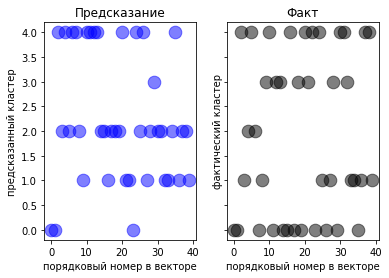

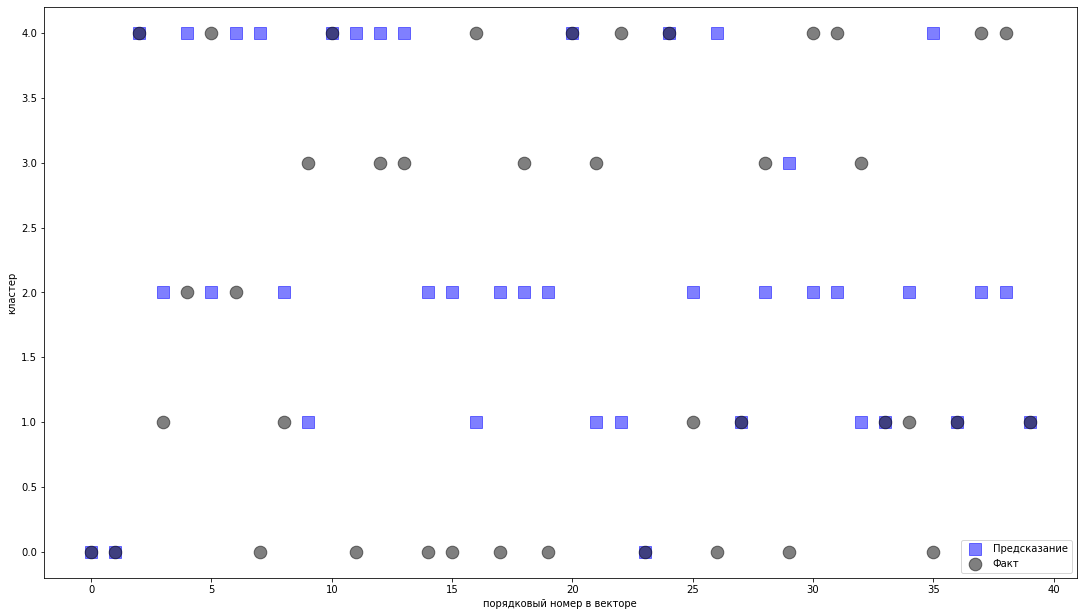

In [99]:

def plotting(x1,x2,y1,y2):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    color1 = 'blue'
    area = 160  
    ax1.scatter(x1, y1, s=area, c=color1, alpha=0.5)
    ax1.set_title('Предсказание')
    ax1.set_xlabel('порядковый номер в векторе')
    ax1.set_ylabel('предсказанный кластер')

    color2 = 'black'
    ax2.scatter(x2, y2, s=area, c=color2, alpha=0.5)
    ax2.set_title('Факт')
    ax2.set_xlabel('порядковый номер в векторе')
    ax2.set_ylabel('фактический кластер')


    plt.show()


    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax3 = fig.add_subplot(111)
    ax3.scatter(x1, y1, s=area, c=color1, marker="s", label='Предсказание', alpha=0.5)
    ax3.scatter(x2,y2, s=area, c=color2, marker="o", label='Факт', alpha=0.5)
    ax1.set_title('Предсказание')
    ax3.set_xlabel('порядковый номер в векторе')
    ax3.set_ylabel('кластер')
    plt.legend(loc='best');
    plt.show()



plotting(
        x1 = range(0, len(predicted_label),1),
        y1 = predicted_label,
        x2 = range(0, len(target_valid),1),
        y2 = target_valid
    )

Получили какое-то разбиение на кластера. А на сколько это разбиение хорошо? Посмотрим оценку гомогенности.

In [100]:
homogeneity_score(target_valid, predicted_label)

0.2363793622693554

Отлично, посчитали. А это хорошо или плохо? Какой результат выдает константная модель? Может случайным образом присваивать кластера лучше. А еще - было бы неплохо сделать место, куда будем складывать все результаты, чтоб потом было удобно сравнивать.

In [101]:
compare = {}
compare['pure_kMean_with_known_clusters'] = [5,homogeneity_score(target_valid, predicted_label)]

In [102]:
def constant_predictions(predicted_label, random_state):
    
    predicted_label_random = random_state.randint(0, high=5, size=len(predicted_label), dtype=int)
    
    return predicted_label_random

compare['random_clustering'] = [5,homogeneity_score(target_valid, constant_predictions(predicted_label, np.random.RandomState(3)))]
homogeneity_score(target_valid, constant_predictions(predicted_label, np.random.RandomState(3)))

0.14232957454316783

Нуууу.... по крайней мере кластеризация методом к-средних более точная, чем случайное присвоение меток класса. Не то чтобы к-средних хорошо справился с задачей, но зато быстро. 





Вообще, это конечно круто, проверять как разбивает, если мы знаем кластеры. 

### А что если...
мы не знаем количество кластеров? Что если нужно определить количество кластеров и разбить по ним? Можно и такое. Но встает вопрос "как определить количество кластеров, на которые разбивать". На этот вопрос есть ответ - "Elbow method". Попробуем представить, что у нас нет тренировочной и валидационной выборок, а есть только 1 и нам нужно разбить ее на кластеры. 

Для начала определим количество кластеров, на которые нужно разбивать данные.

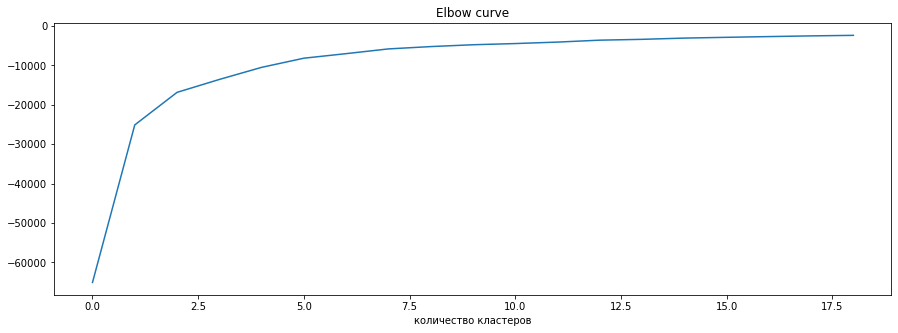

In [103]:
scores = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features)
    scores.append(km.score(features))


fig = plt.figure(figsize=(15, 5))
plt.plot(range(0, len(scores),1), scores)
plt.xlabel('количество кластеров')
plt.title('Elbow curve')
plt.show()

Отлично, видно, что локоть у нас в районе от 2 до 5 кластеров, что соответстует действительности (в исходных данных 5 кластеров). Посмотрим на промежутке от 1 до 6 кластеров.

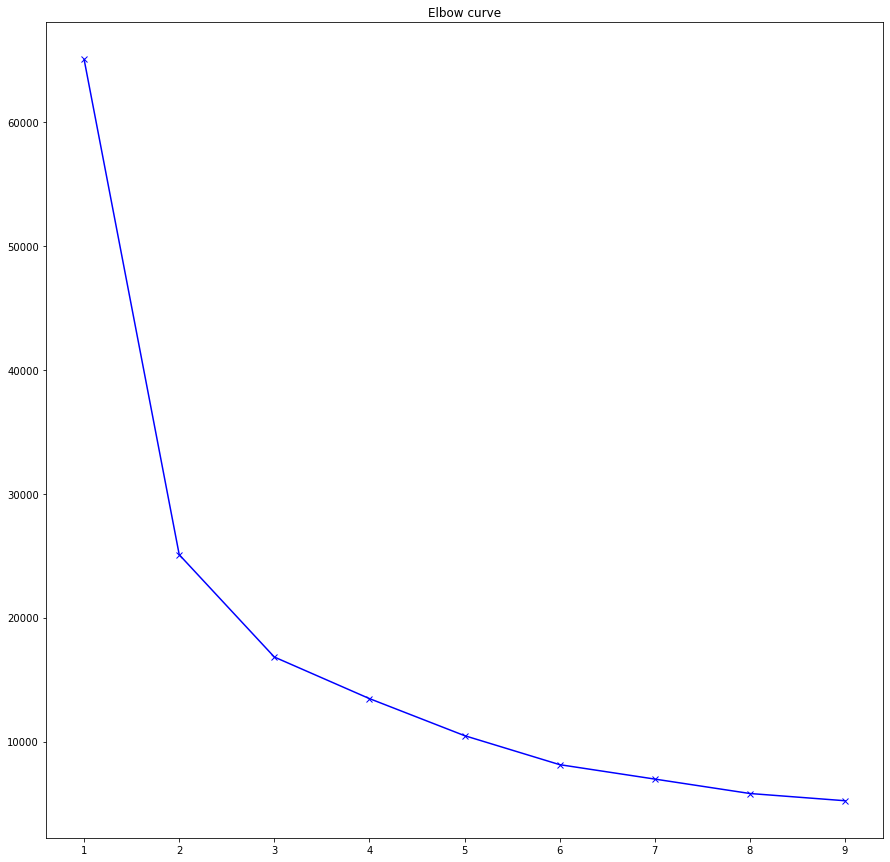

In [104]:
scores = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features)
    scores.append(km.inertia_)


fig = plt.figure(figsize=(15, 15))
plt.plot(range(1, len(scores)+1,1), scores, 'bx-')

plt.title('Elbow curve')
plt.show()

Нууууу... стандартным евклидовым растоянием мы получаем локоть в районе 3 кластеров и должны разбить данные на 3 кластера.
Тогда наша кластеризация выглядела бы так

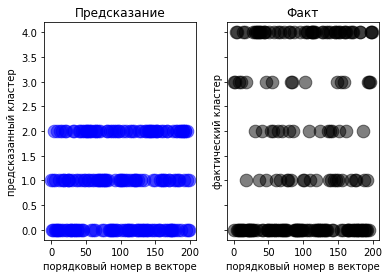

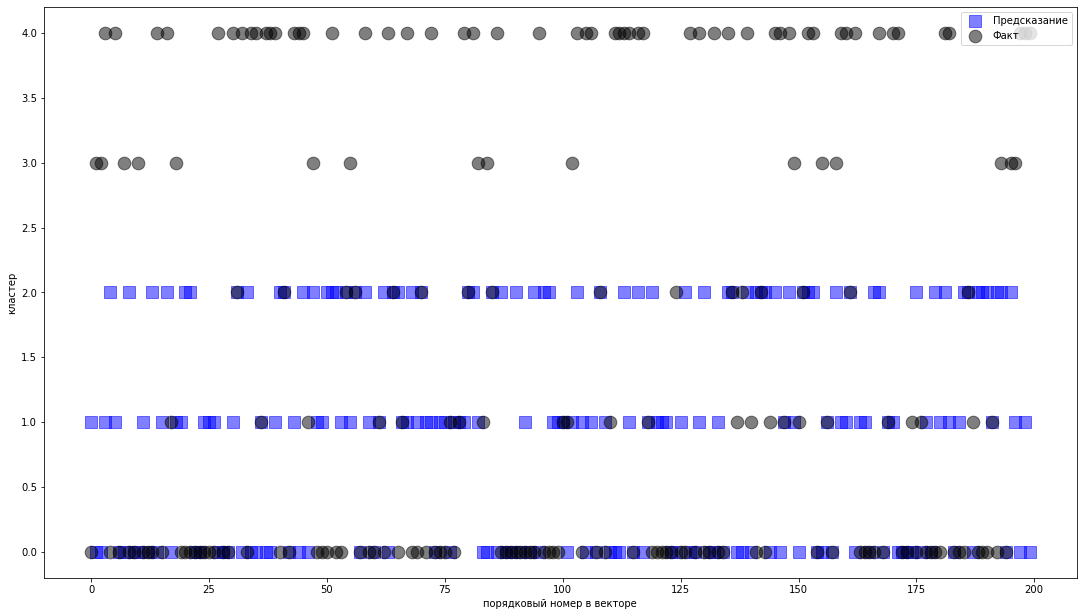

In [105]:
model=KMeans(n_clusters=3)
predicted_label = model.fit(features).predict(features)

plotting(
        x1 = range(0, len(predicted_label),1),
        y1 = predicted_label,
        x2 = range(0, len(target),1),
        y2 = target
    )

И оценка гомогенности

In [106]:
compare['pure_kmean_with_unknown_clusters'] = [3,homogeneity_score(target,predicted_label)]

print('Оценка гомогенности модели кластеризации:{: .4f}'.format(homogeneity_score(target,predicted_label)))
print('Оценка гомогенности "случайной" кластеризации:{: .4f}'.format(homogeneity_score(target, constant_predictions(predicted_label, np.random.RandomState(3)))))

Оценка гомогенности модели кластеризации: 0.0789
Оценка гомогенности "случайной" кластеризации: 0.0250


### Иерархическая кластеризация

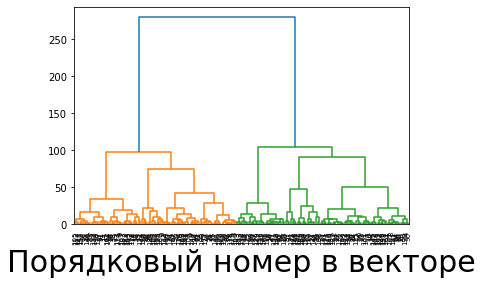

<Figure size 1440x2160 with 0 Axes>

In [107]:

varieties = range(0, len(predicted_label),1)

# Извлекаем измерения как массив NumPy
samples = features.values

# Реализация иерархической кластеризации при помощи функции linkage
# method=’single’  - KNN
# method=’complete’ - Алгоритм Voor Hees
# method='ward' - Метод минимальной дисперсии Уорда
# method='centroid' - Unweighted Pair Group Method with Centroid average
# method='average' - Агломерационной иерархическая кластеризация UPGMA
# method='weighted'- Агломерационная иерархическая кластеризация Сокала и Михенеру
# method='median' - WPGMC 

mergings = linkage(samples, method='ward' )

# Строим дендрограмму, указав параметры удобные для отображения
dendrogram(mergings,
           labels=varieties,
           leaf_rotation=90,
           leaf_font_size=7
           )

plt.xlabel('Порядковый номер в векторе', fontsize=30)

plt.figure(figsize=(20,30))
plt.show()

Тут, как в случае и с первой попыткой кластеризации методом K-средних, мы предположим, что знаем, что у нас 5 кластеров и посмотрим, насколько точно кластеризует.

In [108]:
# вытащим кластера
f = fcluster(mergings,5,criterion='maxclust')

# сложим их в датафрейм
temp = pd.DataFrame({'drug': target, 'cluster':f}).pivot_table(index='drug', values='cluster', aggfunc='count')

# посчитаем размер реальных кластеров из входных данных
count_target_unique = {}
for el in target.unique():
    count_target_unique[el] = target[target == el].count()

# посмотрим как наша кластеризация соотностится со входными данными
temp['real_number_of_items_in_the_cluster'] = pd.Series(count_target_unique)
display(temp)

compare['pure_hierarchy_with_known_clusters'] = [5,homogeneity_score(target,f)]
print('Оценка гомогенности модели кластеризации:{: .4f}'.format(homogeneity_score(target,f)))
print('Оценка гомогенности "случайной" кластеризации:{: .4f}'.format(homogeneity_score(target, constant_predictions(f, np.random.RandomState(3)))))

,cluster,real_number_of_items_in_the_cluster
drug,,
0.0,91,91
1.0,23,23
2.0,16,16
3.0,16,16
4.0,54,54


Оценка гомогенности модели кластеризации: 0.1501
Оценка гомогенности "случайной" кластеризации: 0.0250


Опять, оценка гомогенности модели кластеризации выше оценки гомогенности "случайной" кластеризации. При этом соблюдена размерность кластеров но сама по себе кластеризация хуже чем методом к-средних при известном количестве кластеров, но лучше чем к-средних при не известном количестве кластеров. 

Про состав класеров - отдельный вопрос, как и про то, сколько кластеров мы хотим увидеть.

### GMM

Попробуем кластеризовать гауссовской моделью, которая пытается найти такую смесь многомерных гауссовых распределений вероятностей, которая наилучшим образом моделирует входной набор данных. 
На первом этапе, как и в случае с К-средних, перед нами встает вопрос выбора количества кластеров. Тут нам на помощь приходят 2 критерия которые показывают компромисс между точностью и сложностью модели: баессовский информационный (bic) и информационный критерий Акаике. Оба критерия, чем меньше - тем лучше. 

Пришло время проверить

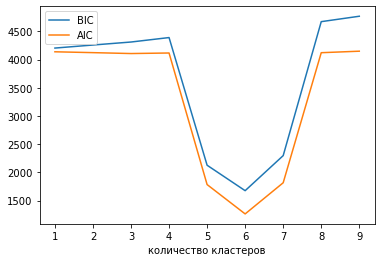

In [109]:
n_components = range(1,10)
models = [GMM(n, covariance_type='full', random_state=0).fit(features) for n in n_components]

plt.plot(n_components, [m.bic(features) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('количество кластеров');

Ну чтож... 6 так шесть.

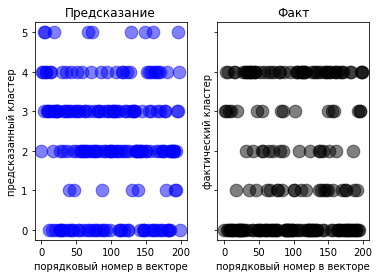

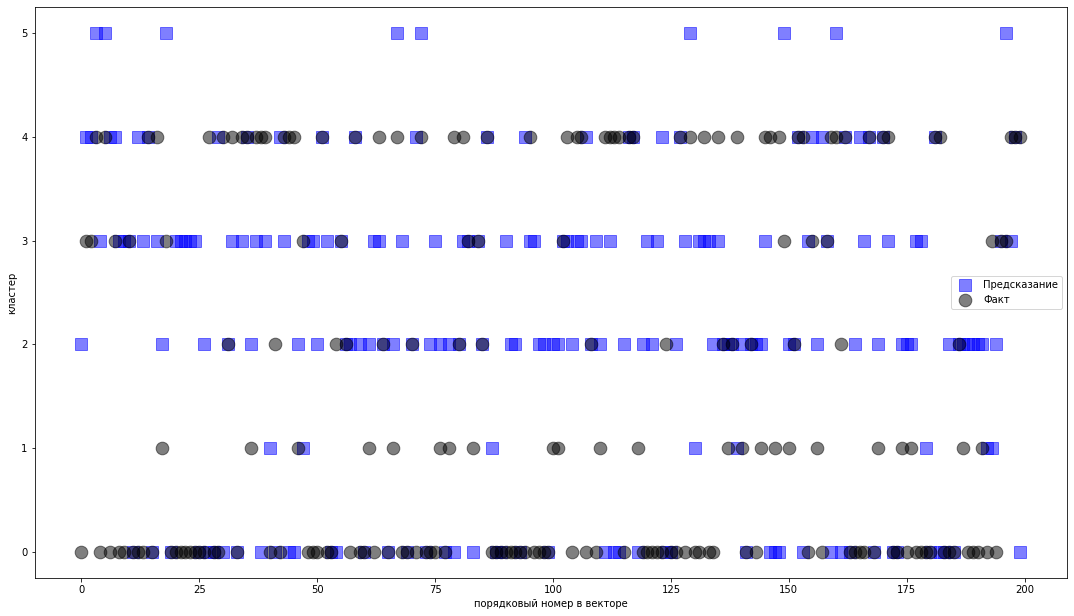

In [110]:
model = GMM(6, covariance_type='full', random_state=0)
model.fit(features)
predicted_label = model.predict(features)

plotting(
        x1 = range(0, len(predicted_label),1),
        y1 = predicted_label,
        x2 = range(0, len(target),1),
        y2 = target
    )

In [111]:
compare['pure_GMM_with_unknown_clusters'] = [6,homogeneity_score(target,predicted_label)]
print('Оценка гомогенности модели кластеризации:{: .4f}'.format(homogeneity_score(target,predicted_label)))
print('Оценка гомогенности "случайной" кластеризации:{: .4f}'.format(homogeneity_score(target, constant_predictions(predicted_label, np.random.RandomState(3)))))

Оценка гомогенности модели кластеризации: 0.2600
Оценка гомогенности "случайной" кластеризации: 0.0250


Уже намного лучше, оценка гомогенности выше чем у кластеризации методом к-средних при известном количестве кластеров. Это прямо хорошо. Плохо только, что истенное количество кластеро - 5, а модель нам дала 6.

### K-Medoids

Попробуем кластеризовать методом K-медоидов, а именно, будем использовать PAM-алгоритм, который выбирает центр кластеров среди кластеризуемых объектов. Эти центры и называются медоидами. 
Основное отличие от к-средних заключается в том, что PAM сводит к минимуму сумму различий, а к-средних - сумму квадратов евклидового расстояния.

Основная проблема алгоритма PAM заключается в том, что необходимо задавать количество медоидов на первом шаге. Затем алгоритм проходит следуюшие шаги: 

***1)*** Случайно выбирает заданное количество точек и наазначает их медоидами 

***2)*** Рассчитывает матрицу расстояний Минковского от всех точек до ближайшего медоида
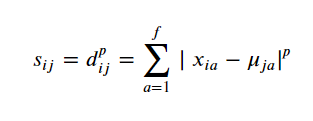
где растояние порядка p между двумя точками задается формулой 
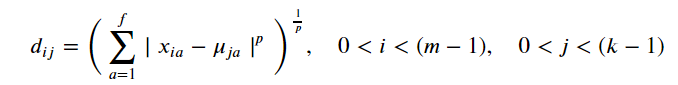


Вообще, расстояние Минковского обычно используется с 𝑝 равным 1 или 2, которые соответствуют Манхэттенскому расстоянию и евклидову расстоянию соответственно. Мы будем использовать евклидово расстояние в наших расчетах, для более корректного сравнения с методом кластеризации k-means

***3)*** Формирует кластер. Для каждой точки, обозначенной индексом строки 𝑖 , если 𝑠_𝑖𝑗 - это минимальное расстояние для 𝑖-ой точки, то 𝑗-ый индекс показывает к какому кластеру относится i-ая точка. Другими словами:
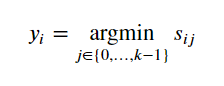

***4)*** Проверяет кластер на устойчивость. Для каждого кластера ищет, если ли в кластере такая точка, которая уменьшает средний коэффициент несходства. Если таких точек несколько, то  в качестве нового медоида этого кластера выберает ту, которая больше всего уменьшает этот коэффициент и переходит на шаг 2.Если таких точек не существует, то алгоритм заверщает работу.

In [112]:
import numpy as np
from numpy.random import choice
from numpy.random import seed

def init_mediods(X,k):
        
        seed(1)
        samples = choice(len(X), size = k, replace=False)
        return X[samples, :]

def computer_d_p(X, medoids, p):
   
    m = len(X)
    medoids_shape = medoids.shape
    
    if len(medoids_shape) == 1:
        medoids = medoids.reshape((1, len(medoids)))
   
    k = len(medoids)
    
    S = np.empty((m,k))
    for i in range(m):
        d_i = np.linalg.norm(X[i,:] - medoids, ord=p, axis=1)
        S[i,:]=d_i**p
    return S

def assign_lables(S):
   
    return np.argmin(S, axis=1)

def update_medoids(X, medoids,p):
    
    S = computer_d_p(X, medoids, p)
    lables = assign_lables(S)
    out_medoids = medoids
    
    for i in set(lables):
        
        avg_dissimilarity = np.sum(computer_d_p(X, medoids[i], p))
        
        cluster_points = X[lables == i]
        
        for datap in cluster_points:
            
            new_medoids = datap
            new_dissimilarity = np.sum(computer_d_p(X, datap, p))
            
            if new_dissimilarity < avg_dissimilarity:
                avg_dissimilarity = new_dissimilarity
                out_medoids = datap
    
    return out_medoids

def has_converged(old_medoids, medoids):
    if set([tuple(x) for x in old_medoids]) == set([tuple(x) for x in medoids.reshape((1, len(medoids)))]):
        return True

def kmedoids(X, k, p, starting_medoids = None, max_steps = np.inf):
    
    if starting_medoids is None:
        
        medoids = init_mediods(X,k)
    else:
        medoids = starting_medoids
    
    converged = False
    lables = np.zeros(len(X))
    i=1
    while (converged !=True) and (i<=max_steps):
        old_medoids = medoids.copy()
        S = computer_d_p(X, medoids, p)
        labels = assign_lables(S)
        medoids = update_medoids(X, medoids, p)
        converged = has_converged(old_medoids, medoids)
        i+=1
        return (medoids, labels)
    
    
results = kmedoids(features.values, 5, 2)
final_medoids = results[0]
clusters = results[1]

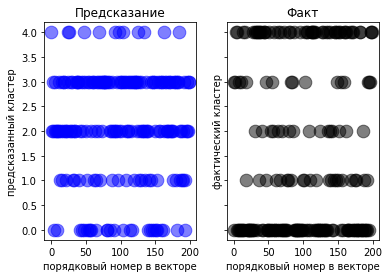

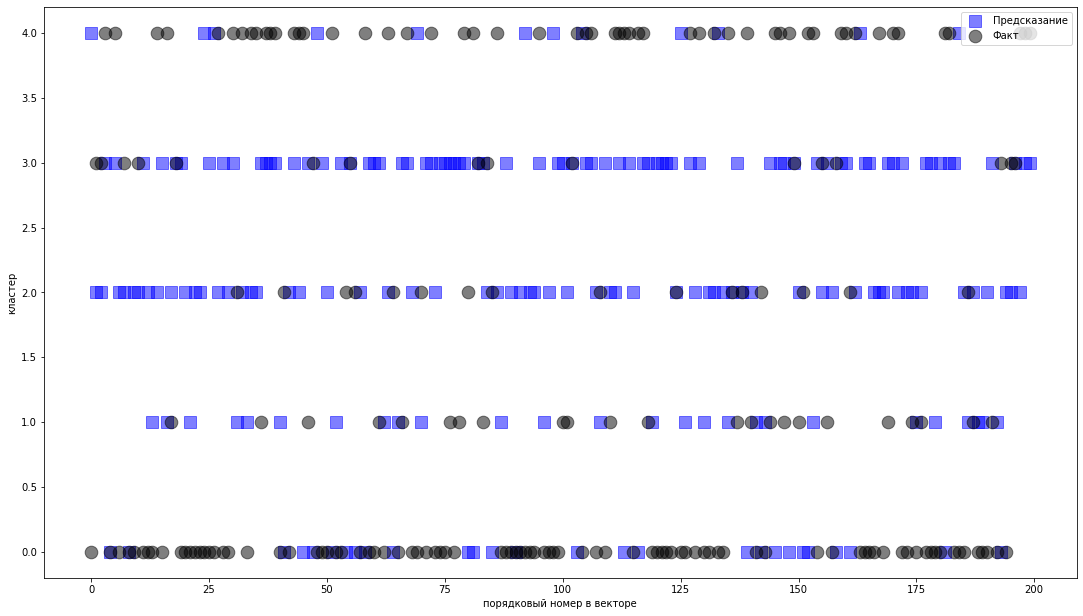

In [113]:
plotting(
        x1 = range(0, len(clusters),1),
        y1 = clusters,
        x2 = range(0, len(target),1),
        y2 = target
    )


In [114]:
compare['pure_kMedoids_with_known_clusters'] = [5,homogeneity_score(target,clusters)]
print('Оценка гомогенности модели кластеризации:{: .4f}'.format(homogeneity_score(target,clusters)))
print('Оценка гомогенности "случайной" кластеризации:{: .4f}'.format(homogeneity_score(target, constant_predictions(clusters, np.random.RandomState(3)))))

Оценка гомогенности модели кластеризации: 0.1621
Оценка гомогенности "случайной" кластеризации: 0.0250


Нуууу... не так уж и хорошо. После GMM у которого коэффицент гомогенности 0.26 при условии неизвестного заранее числа кластеров, получить 0.16 при заданном заранее количестве кластеров - это такой себе результат.

### DBSCAN и уменьшение размерности матрицы признаков методом главных компонент (PCA)

Посмотрим еще раз на матрицу признаков

In [115]:
features.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0.0,0.0,0.0,25.355
1,47,1.0,1.0,0.0,13.093
2,47,1.0,1.0,0.0,10.114
3,28,0.0,2.0,0.0,7.798
4,61,0.0,1.0,0.0,18.043


Каждый признак имеет свою размерность, а значит и влияние каждого признака на конечный результат - разное. Стандартизируем переменные (приведем их к стреднему 0 и дисперсии 1) стандартной функцией библиотеки sklearn. При этом будем логичны: не имеет смысл стандартизовать категориальные переменные и переменные (а таких переменных у нас 3)

In [116]:
# стандартизация независимых переменных

def scaler(features):
    # определим все числовие независимые переменные
    
    numeric = features[['Age','Cholesterol','Na_to_K']].columns.to_list()


    # обучим стандартизации на тренировочных данных
    scaler = StandardScaler()
    scaler.fit(features[numeric])


    # стандартизируем выборки
    features_scaler = features.copy() 


    features_scaler[numeric] = scaler.transform(features[numeric])
    
    return features_scaler

features_scaler = scaler(features)





Посмотрим максимальную метку класса

In [117]:
# Определяем модель
dbscan = DBSCAN()

# Обучаем
dbscan.fit(features_scaler)

# Уменьшаем размерность при помощи метода главных компонент

n_components = 2
pca = PCA(n_components = n_components).fit(features_scaler)
pca_2d = pca.transform(features_scaler)

max(dbscan.labels_)

2

Мда.... Значит алгоритм нашел у нас только 3 кластера (0, 1 и 2) и шум (-1). Даже если объединить шум в 1 кластер, то все равно не получим 5 кластеров, как в изначальной задаче.
Поскольку мы привели в 2-х мерное пространство, то можем визуализировать 

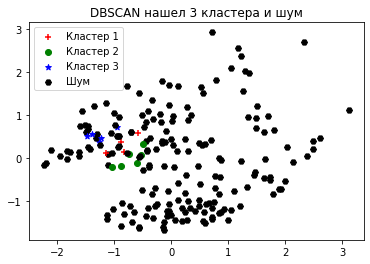

In [118]:
# Строим в соответствии с тремя классами
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='red', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='green', marker='o')
    elif dbscan.labels_[i] == 2:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='blue', marker='*')
    elif dbscan.labels_[i] == -1:
        c4 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='black', marker='H')

plt.legend([c1, c2, c3, c4], ['Кластер 1', 'Кластер 2', 'Кластер 3', 'Шум'])
plt.title('DBSCAN нашел 3 кластера и шум')
plt.show()

А теперь посмотрим, сколько же нам нужно главных компонент. Обычно выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных.

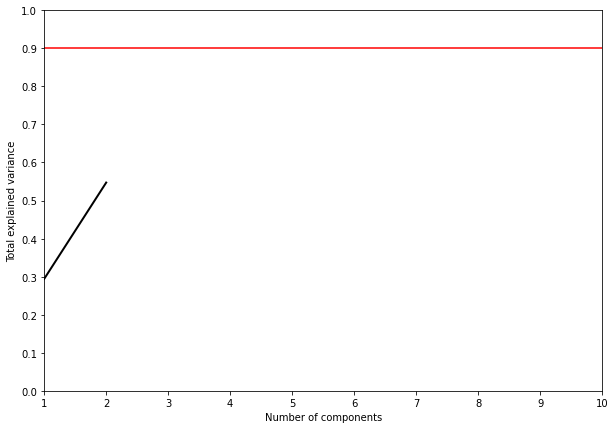

In [119]:
def plotting_pca_components(pca,n):
    plt.figure(figsize=(10,7))

    plt.plot(range(1,n+1), np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)

    plt.xlabel('Number of components')
    plt.ylabel('Total explained variance')

    plt.xlim(1, 10)
    plt.yticks(np.arange(0, 1.1, 0.1))

    plt.axhline(0.9, c='r')
    plt.show()
n_components = 2   
plotting_pca_components(pca, n_components)

Двух явно не хваратет. Попробуем 4 и посмотрим, если хватит 3х, то мы это увидим


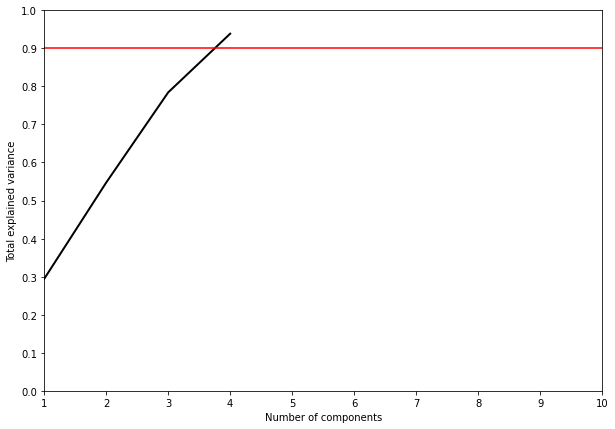

In [120]:
n_components = 4
pca = PCA(n_components = n_components).fit(features_scaler)
pca_2d = pca.transform(features_scaler)
plotting_pca_components(pca, n_components)


Отлично, значит для стандартизированных данных уменьшить размерность не очень получится, а что если для не стандартизированных?

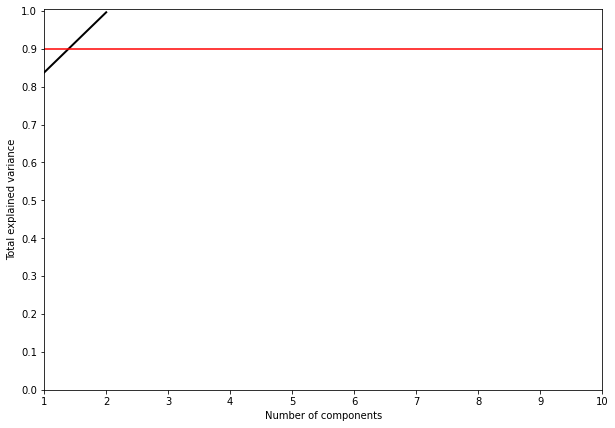

In [121]:
n_components = 2
pca = PCA(n_components=n_components).fit(features)
plotting_pca_components(pca,n_components)




Отлично, для нестандертизированных данных хватает и двух главных компонент. Итого: используем нестандартизированные признаки, которые методом главных компонент сворачиваем до точки в двумерном пространстве, затем стандартизируем и тольок потом кластеризуем алгоритмом dbscan 

In [122]:
# обучаем модель
pca = PCA(n_components = 2).fit(features)

# сворачиваем до 2х координат
pca_2d = pca.transform(features)

# стандартизируем
model = StandardScaler()
model = model.fit(pca_2d)
pca_2d_scaler = model.transform(pca_2d)

# кластеризуем
dbscan.fit(pca_2d_scaler )

DBSCAN()

Посмотрим максимальную метку класса

In [123]:
max(dbscan.labels_)


1

Ну супер. Если мы сворачиваем до 2х компонент, то алгоритм находит только 2 класса и шумы.

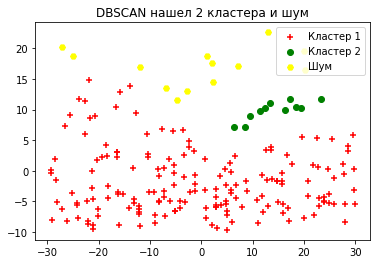

In [124]:
# Строим в соответствии с тремя классами
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='red', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='green', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='yellow', marker='H')


plt.legend([c1, c2, c3], ['Кластер 1', 'Кластер 2', 'Шум'])
plt.title('DBSCAN нашел 2 кластера и шум')
plt.show()

Не сказать что алгоритм хорошо кластеризует.

### GMM и K-mean со сверткой методом главных компонент (PCA) и со стандартизацией

А что, если мы попробуем GMM кластеризацию на "свернутых" не стандартизованных данных? Сначала найдем оптимальное число кластеров.

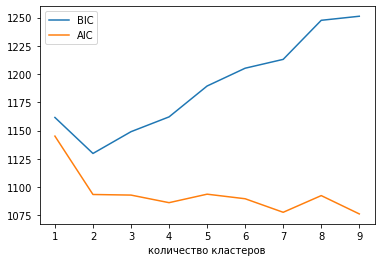

In [125]:
n_components = range(1,10)
models = [GMM(n, covariance_type='full', random_state=0).fit(pca_2d_scaler) for n in n_components]

plt.plot(n_components, [m.bic(pca_2d_scaler) for m in models], label='BIC')
plt.plot(n_components, [m.aic(pca_2d_scaler) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('количество кластеров')
plt.show()

Оптимальное число кластеров также находится в районе 2х.

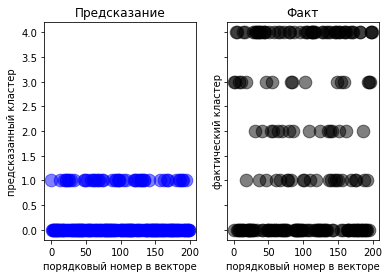

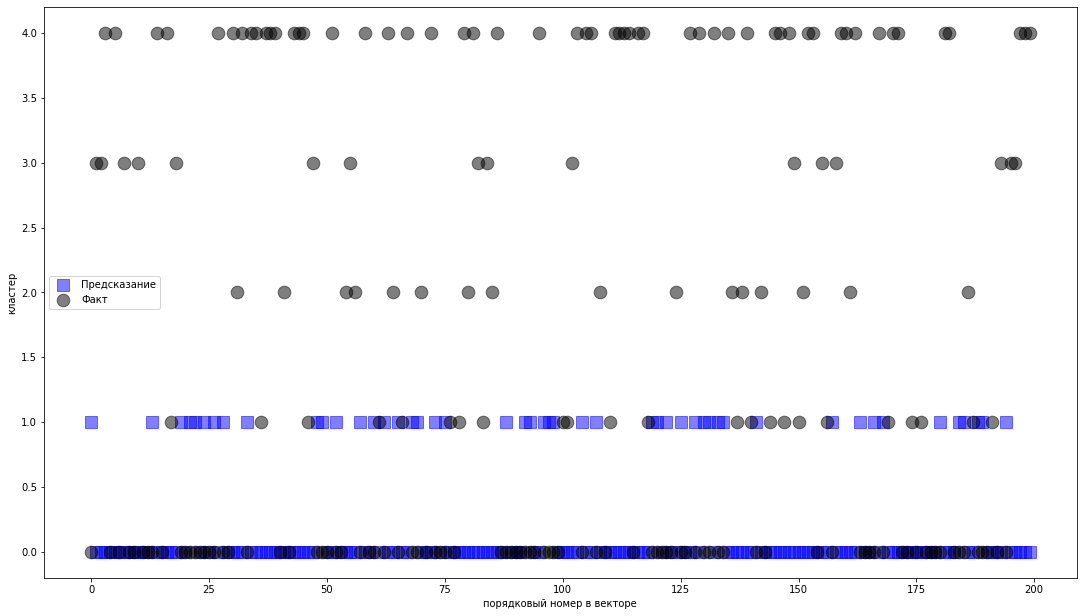

Оценка гомогенности модели кластеризации: 0.1732
Оценка гомогенности "случайной" кластеризации: 0.0250


In [126]:
model = GMM(2, covariance_type='full', random_state=0)
model.fit(pca_2d_scaler)
predicted_label = model.predict(pca_2d_scaler)

plotting(
        x1 = range(0, len(predicted_label),1),
        y1 = predicted_label,
        x2 = range(0, len(target),1),
        y2 = target
    )

compare['pca_GMM_with_unknown_clusters'] = [2,homogeneity_score(target,predicted_label)]
print('Оценка гомогенности модели кластеризации:{: .4f}'.format(homogeneity_score(target,predicted_label)))
print('Оценка гомогенности "случайной" кластеризации:{: .4f}'.format(homogeneity_score(target, constant_predictions(predicted_label, np.random.RandomState(3)))))

После GMM у которого коэффицент гомогенности 0.26 при условии отсутствия свертки и стандартизации, получить 0.17 - это такой себе результат
А как насчет K-средних?

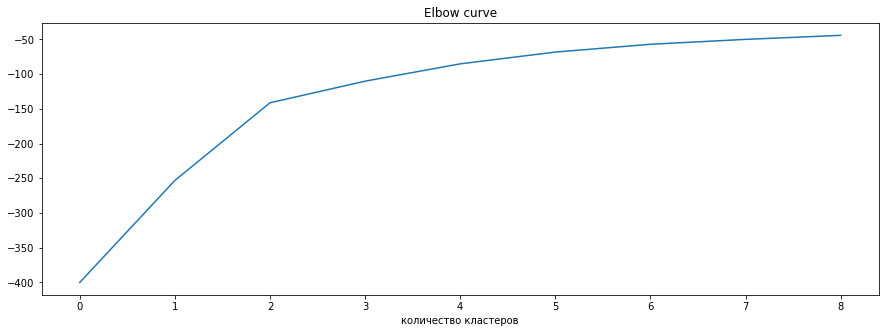

In [127]:
scores = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pca_2d_scaler)
    scores.append(km.score(pca_2d_scaler))


fig = plt.figure(figsize=(15, 5))
plt.plot(range(0, len(scores),1), scores)
plt.xlabel('количество кластеров')
plt.title('Elbow curve')
plt.show()

И тут 2 кластера

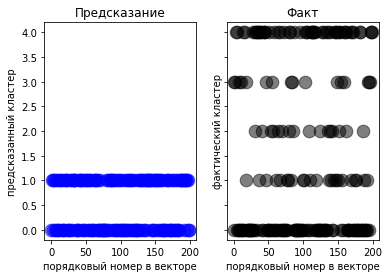

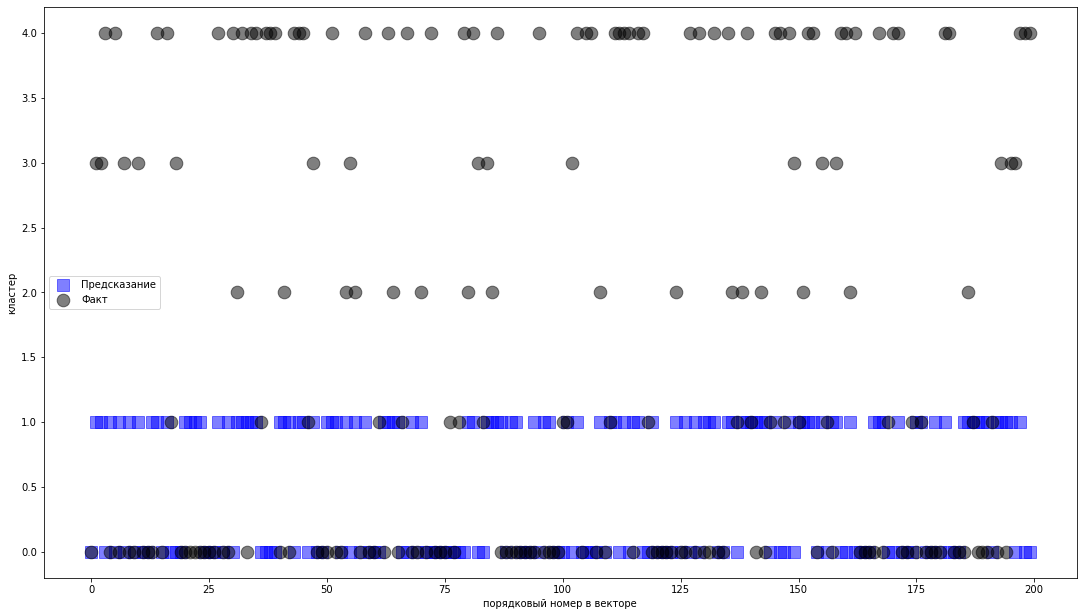

Оценка гомогенности модели кластеризации: 0.0522
Оценка гомогенности "случайной" кластеризации: 0.0250


In [128]:
model = KMeans(n_clusters = 2)
model.fit(pca_2d_scaler)
predicted_label = model.predict(pca_2d_scaler)

plotting(
        x1 = range(0, len(predicted_label),1),
        y1 = predicted_label,
        x2 = range(0, len(target),1),
        y2 = target
    )
compare['pca_kMean_with_unknown_clusters'] = [2,homogeneity_score(target,predicted_label)]
print('Оценка гомогенности модели кластеризации:{: .4f}'.format(homogeneity_score(target,predicted_label)))
print('Оценка гомогенности "случайной" кластеризации:{: .4f}'.format(homogeneity_score(target, constant_predictions(predicted_label, np.random.RandomState(3)))))

Ну такое себе. 

А если K-mean и GMM просто на стандартизованных данных?

In [129]:
features_scaler = scaler(features)
features_scaler

,Age,Sex,BP,Cholesterol,Na_to_K
0,-1.291591,0.0,0.0,-0.970437,1.286522
1,0.162699,1.0,1.0,-0.970437,-0.415145
2,0.162699,1.0,1.0,-0.970437,-0.828558
3,-0.988614,0.0,2.0,-0.970437,-1.149963
4,1.011034,0.0,1.0,-0.970437,0.271794
...,...,...,...,...,...
195,0.708057,0.0,1.0,-0.970437,-0.626917
196,-1.715759,1.0,1.0,-0.970437,-0.565995
197,0.465676,1.0,2.0,-0.970437,-0.859089
198,-1.291591,1.0,2.0,1.030464,-0.286500


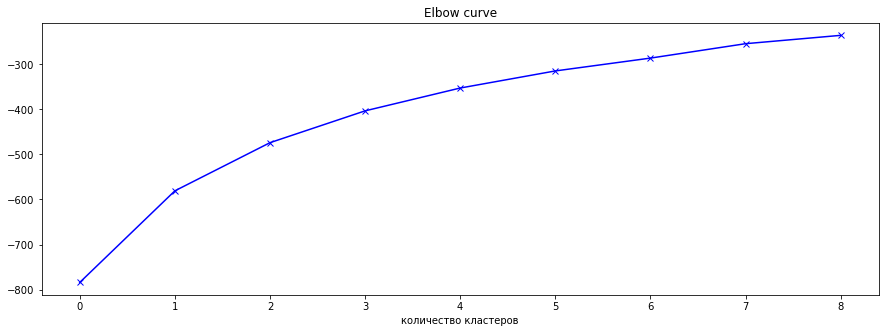

In [130]:
scores = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_scaler)
    scores.append(km.score(features_scaler))


fig = plt.figure(figsize=(15, 5))
plt.plot(range(0, len(scores),1), scores,'-bx')
plt.xlabel('количество кластеров')
plt.title('Elbow curve')
plt.show()

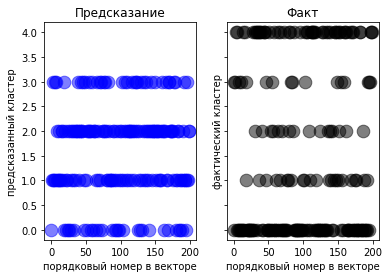

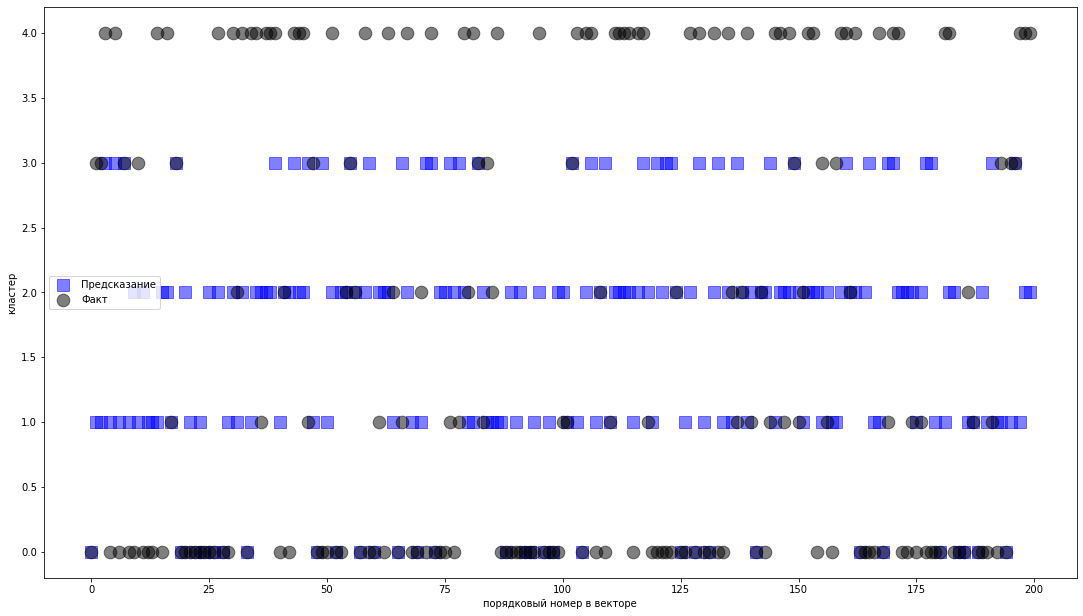

Оценка гомогенности модели кластеризации: 0.1801
Оценка гомогенности "случайной" кластеризации: 0.0250


In [131]:
model=KMeans(n_clusters=4)
predicted_label = model.fit(features_scaler).predict(features_scaler)

plotting(
        x1 = range(0, len(predicted_label),1),
        y1 = predicted_label,
        x2 = range(0, len(target),1),
        y2 = target
    )
compare['scaler_kMean_with_unknown_clusters'] = [4,homogeneity_score(target,predicted_label)]
print('Оценка гомогенности модели кластеризации:{: .4f}'.format(homogeneity_score(target,predicted_label)))
print('Оценка гомогенности "случайной" кластеризации:{: .4f}'.format(homogeneity_score(target, constant_predictions(predicted_label, np.random.RandomState(3)))))

Неплохо. Кластеризация к-средними, со стандартизацией не категориальных признаков и без свертки методом галавных компонент в 1.5 раза более точная, чем просто прямая кластеризация методом к-средних

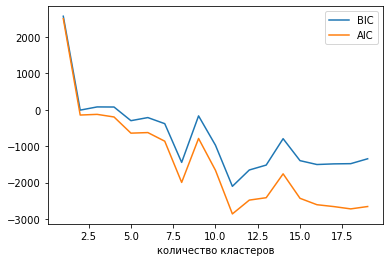

In [132]:
n_components = range(1,20)
models = [GMM(n, covariance_type='full', random_state=0).fit(features_scaler) for n in n_components]

plt.plot(n_components, [m.bic(features_scaler) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features_scaler) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('количество кластеров')
plt.show()

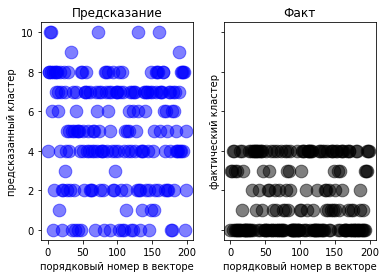

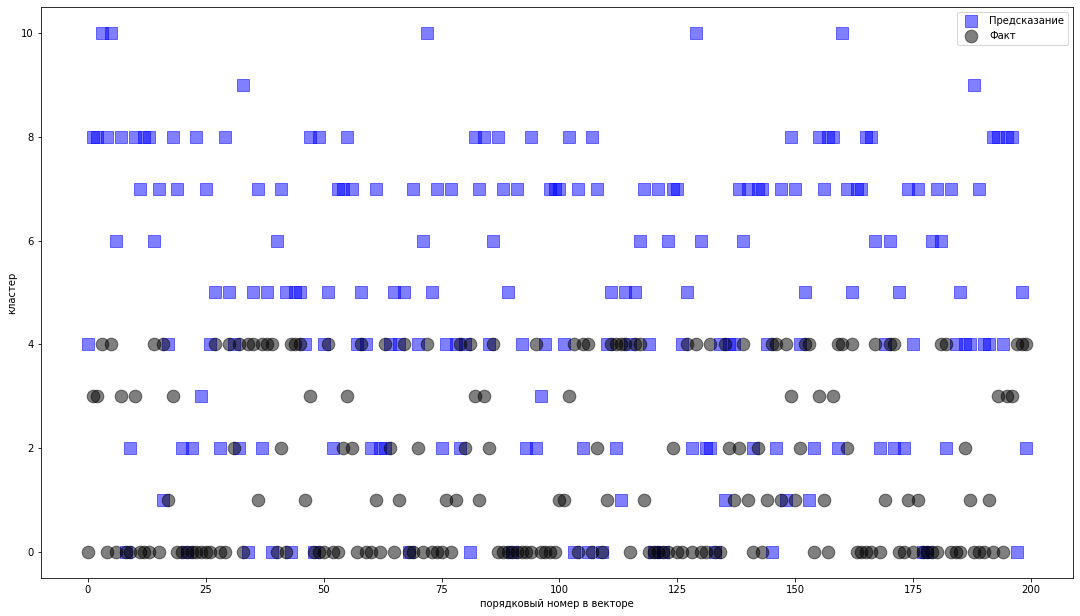

Оценка гомогенности модели кластеризации: 0.4429
Оценка гомогенности "случайной" кластеризации: 0.0250


In [133]:
model = GMM(11, covariance_type='full', random_state=0)
model.fit(features_scaler)
predicted_label = model.predict(features_scaler)

plotting(
        x1 = range(0, len(predicted_label),1),
        y1 = predicted_label,
        x2 = range(0, len(target),1),
        y2 = target
    )
compare['scaler_GMM_with_unknown_clusters'] = [11,homogeneity_score(target,predicted_label)]
print('Оценка гомогенности модели кластеризации:{: .4f}'.format(homogeneity_score(target,predicted_label)))
print('Оценка гомогенности "случайной" кластеризации:{: .4f}'.format(homogeneity_score(target, constant_predictions(predicted_label, np.random.RandomState(3)))))

In [134]:
comparising_table = pd.DataFrame(
    [{"method": key,'num_clusters':num, 'homogeneity score':value} for key, (num, value) in compare.items()])

display (comparising_table.sort_values(by = 'homogeneity score'))

,method,num_clusters,homogeneity score
7,pca_kMean_with_unknown_clusters,2,0.052224
2,pure_kmean_with_unknown_clusters,3,0.078929
1,random_clustering,5,0.142330
3,pure_hierarchy_with_known_clusters,5,0.150057
5,pure_kMedoids_with_known_clusters,5,0.162076
6,pca_GMM_with_unknown_clusters,2,0.173220
8,scaler_kMean_with_unknown_clusters,4,0.180072
0,pure_kMean_with_known_clusters,5,0.236379
4,pure_GMM_with_unknown_clusters,6,0.259960
9,scaler_GMM_with_unknown_clusters,11,0.442908


Все супер, мы получили максимальные (среди ранее расмотренных) оценки гомогенности. Однако, надо вспомнить, что такое "оценка гомогенности". А это - оценка однородности, то есть насколько однородные элементы входят в кластер. Таким образом, зная, что у нас есть 5 классов, можем сказать, что в первые 5 классов попало достаточно элементов, которые в действительности принадлежат этим классам.


### Вывод
задача кластеризации - не тривиальная задача и в ней существует множество подходов и множество критериев, необходимо тщательно подбирать алгоритмы кластеризации и алгоритмы расчета расстояния между точками. Но даже при условии тщательно подготовки нет 100% гарантии, что все будет кластеризованно правильно, мы можем только с определенной долей уверенности сказать, что истенное количество кластеров находится в определенном диапазоне.